# Fit Q-Learning model to Human Pilot Data

In [1]:
import plotly.graph_objects as go
import plotly.express as px
from tqdm import tqdm
import pandas as pd

import numpy as np
import statistics
import scipy.io
import logging
import pprint
import os


# internals
from src.helpers import log_rat_metadata, log_sequence_data, load_config
from src.query_dataset import (QuerySequenceData, load_data)

In [2]:
from src.rescorla_wagner_model import (RoscorlaWagner)
from src.rescorla_wagner_model_plots import (RescorlaWagnerPlots)
from src.rescorla_wagner_model_simulation import (RescorlaWagnerSimulate)
from src.rescorla_wagner_model_diagnostics import (RoscorlaWagerModelDiagnostics)

In [3]:
# load yaml config
_config = load_config('config.yaml')
logging.basicConfig(level=logging.INFO)


----
# Human Pilot Data
----

In [4]:
(data,
 sequence_data,
 meta_data,
 StimCode,
 RespCode
 ) = load_data(config=_config, experiment_class='human_pilot_experiment')

INFO:root:StimCode (284): [0. 1.]
INFO:root:RespCode (284): [1. 4.]


In [5]:
# define experiment runtime parameters
subject_ID = 1
session_Type = 'ams1'
session_Type = 'training'
session_Type = None
session_Num = None
KEY = (subject_ID, session_Type, session_Num)

# contruct query sequence data object
qsd = QuerySequenceData(StimCode, RespCode)

# filter sequence data based on subjectID and sessionType
qsd.filter_sequences(*KEY)

# Extract stimData & resp: concatenate all IDS or EDS sessions. assuming sorting isn't required.) Result: ( qsd._stimCodeFlat, qsd._respCodeFlat)
qsd.extract_stim_resp_data()

# infer action / reward pairs
qsd.infer_action_reward_pairs()
print('Overall Reward Rate: ', np.mean(qsd._reward))


Overall Reward Rate:  0.7071428571428572


---
# Define Experiment Set
---

- Concatenate all `IDS` & `EDS` data into a long sequence.

In [6]:
session_Types = np.unique([k[1] for k in StimCode.keys()])
session_Types

session_Groups = [
    ['ams1', 'ams2'],
    ['eds1', 'eds2'],
    ['ids1', 'ids2'],
    ['staircase1', 'staircase2'],
    ['training']
    ]

subject_IDs = np.unique([k[0] for k in StimCode.keys()])

# groupings: (subject_ID, <session_Groups>, <all>)
experiments = []
for _subject in subject_IDs:
    for session_Group in session_Groups:
        new_experiment = []
        for _session_Type in session_Group:
            new_experiment.append((_subject, _session_Type, None))
        experiments.append(new_experiment)


experiments[:2]

[[(1, 'ams1', None), (1, 'ams2', None)],
 [(1, 'eds1', None), (1, 'eds2', None)]]

In [13]:
# Text
qsd = QuerySequenceData(StimCode, RespCode)

for _key in experiments[0]:

    # extract data
    qsd.filter_sequences(*_key, update_existing_stim_resp=True)


qsd.extract_stim_resp_data()
qsd.infer_action_reward_pairs()
ACTIONS = qsd._action
REWARDS = qsd._reward

# fit model
param_fits, BIC = RoscorlaWagner.fit_rescorla_wagner_model_n_times(
            action_vector=ACTIONS,
            reward_vector=REWARDS,
            alpha_range=np.linspace(0,1,10),
            theta_range=np.linspace(1,25,10),
            alpha_bound=(0,1),
            theta_bound=(0,50), log=False)

# run model diagnostics
Q_stored, predicted_action_vector, action_probabilities = \
      RoscorlaWagerModelDiagnostics.generate_Q_values(param_fits, action_vector=ACTIONS, reward_vector=REWARDS)


# Calc metrics
metrics = RoscorlaWagerModelDiagnostics.calc_confusion_matrix(ACTIONS, predicted_action_vector, bin_size=None)
# metrics['group_midpoint'] = metrics.apply(lambda x: (x['start_index'] + x['end_index'])/2, axis=1)
metrics



    

{'TP': 0,
 'FP': 120,
 'TN': 120,
 'FN': 0,
 'senstivity': nan,
 'specificity': 0.5,
 'precision': 0.0,
 'recall': nan,
 'accuracy': 0.5,
 'F_score': nan}

---
# Fit Single Experiment (Demo)
----

In [ ]:
# single run
KEY = (22, 'staircase2', 1)

# extract data
qsd = QuerySequenceData(StimCode, RespCode)
qsd.filter_sequences(*KEY)
qsd.extract_stim_resp_data()
qsd.infer_action_reward_pairs()
ACTIONS = qsd._action
REWARDS = qsd._reward

# fit model
# ---- param_fits, BIC = RoscorlaWagner.fit_rescorla_wagner_model_n_times( --- #
            action_vector=ACTIONS,
            reward_vector=REWARDS,
            alpha_range=np.linspace(0,1,10),
            theta_range=np.linspace(1,25,10),
            alpha_bound=(0,1),
            theta_bound=(0,50), log=False)

# run model diagnostics
Q_stored, predicted_action_vector, action_probabilities = \
      RoscorlaWagerModelDiagnostics.generate_Q_values(param_fits, action_vector=ACTIONS, reward_vector=REWARDS)


# Calc metrics
metrics = RoscorlaWagerModelDiagnostics.calc_confusion_matrix(ACTIONS, REWARDS, bin_size=None)
# metrics['group_midpoint'] = metrics.apply(lambda x: (x['start_index'] + x['end_index'])/2, axis=1)
metrics
    


----
# Fit All Experiments
----

In [148]:
experiments[0]
_experiment

[(1, 'ams1', None), (1, 'ams2', None)]

In [198]:
def fit_experiment(experiment_keys, StimCode, RespCode, experiment_id=None):
    """
    Fit a single experiment over the experiment class.

    Args:
    -----
        experiment_keys (list): List of tuples containing the experiment keys.
    """
    # add metrics
    _metrics = ['TP','FP','TN','FN','senstivity','specificity','precision','recall','accuracy','F_score']
    # results.update({k:[] for k in _metrics})

    # extract dataset
    qsd = QuerySequenceData(StimCode, RespCode)
    for experiment in experiment_keys:
        qsd.filter_sequences(*experiment, update_existing_stim_resp=True)

    # extract and flatten action/reward vectors
    qsd.extract_stim_resp_data()
    qsd.infer_action_reward_pairs()
    ACTIONS = qsd._action
    REWARDS = qsd._reward


    try:
        param_fits, BIC = RoscorlaWagner.fit_rescorla_wagner_model_n_times(
            action_vector=ACTIONS,
            reward_vector=REWARDS,
            alpha_range=np.linspace(0,1,10),
            theta_range=np.linspace(1,10,10),
            alpha_bound=(0,1),
            theta_bound=(0,10), log=False)
        
        # run model diagnostics
        Q_stored, predicted_action_vector, action_probabilities = \
            RoscorlaWagerModelDiagnostics.generate_Q_values(param_fits, action_vector=ACTIONS, reward_vector=REWARDS, Q_init=[0.5, 0.5])
    
        # Calc metrics (dict)
        metrics = RoscorlaWagerModelDiagnostics.calc_confusion_matrix(ACTIONS, predicted_action_vector, bin_size=None)
        FAILED_EXPERIMENT = False
    
    except:
        pass

    # describe experiment
    subject_mode = statistics.mode([i[0] for i in experiment_keys])
    session_mode = statistics.mode([i[1] for i in experiment_keys])
    session_num_mode = statistics.mode([i[2] for i in experiment_keys])

    return {
        'experiment_keys': experiment_keys, 
        'subject_ID': subject_mode,
        'session_Type': session_mode,
        'session_Num': session_num_mode,
        'qsd': qsd,
        'ACTIONS': ACTIONS,
        'REWARDS': REWARDS,
        'param_fits': param_fits,
        'BIC': BIC,
        'metrics': metrics,
        'Q_stored': Q_stored,
        'predicted_action_vector': predicted_action_vector,
        'action_probabilities': action_probabilities
    }




In [226]:
def plot_Q_estimates(experiment_result):
    fig = RescorlaWagnerPlots.plot_Q_estimates(Q_values=experiment_result['Q_stored'], choice_vector=actions)
    fig.show()


def plot_reward(experiment_result):
    reward_vector = experiment_result['qsd']._action
    choice_vector = experiment_result['qsd']._reward
    fig = RescorlaWagnerPlots.plot_reward(reward_vector, choice_vector)
    fig.show()


def plot_prob_success(experiment_result, title='', loess_frac=0.5, bin_size=5):

    REWARD_VECTOR =experiment_result['qsd']._reward
    x_vector, prob_of_success = RoscorlaWagerModelDiagnostics.calc_prob_of_success(REWARD_VECTOR, bin_size=5)
    prob_of_success

    frac = loess_frac
    x_loess, y_loess = RoscorlaWagerModelDiagnostics.fit_loess(x_vector, prob_of_success, frac=frac)
    fig = RescorlaWagnerPlots.plot_metric(x_vector, prob_of_success, name='Prob of Success.', title=title)
    fig.add_trace(go.Scatter(x=x_loess, y=y_loess, mode='lines', line_color='red', name=f'loess frac:{frac}'))
    fig.show()

In [228]:
# test
for experiment in experiments:
    _res = fit_experiment(experiment, StimCode, RespCode)
    print(f'Experiment: {experiment}')


    if not (_res['param_fits'][0] == 0 and _res['param_fits'][1] == 1):
        print(f'Experiment fit! {experiment}')
        
    
    plot_prob_success(_res, title=f'params: [{_res['param_fits']}]')

    


Experiment: [(1, 'ams1', None), (1, 'ams2', None)]


Experiment: [(1, 'eds1', None), (1, 'eds2', None)]
Experiment fit! [(1, 'eds1', None), (1, 'eds2', None)]


Experiment: [(1, 'ids1', None), (1, 'ids2', None)]


Experiment: [(1, 'staircase1', None), (1, 'staircase2', None)]


Experiment: [(1, 'training', None)]


Experiment: [(2, 'ams1', None), (2, 'ams2', None)]


Experiment: [(2, 'eds1', None), (2, 'eds2', None)]


Experiment: [(2, 'ids1', None), (2, 'ids2', None)]
Experiment fit! [(2, 'ids1', None), (2, 'ids2', None)]


Experiment: [(2, 'staircase1', None), (2, 'staircase2', None)]


Experiment: [(2, 'training', None)]


Experiment: [(3, 'ams1', None), (3, 'ams2', None)]
Experiment fit! [(3, 'ams1', None), (3, 'ams2', None)]


Experiment: [(3, 'eds1', None), (3, 'eds2', None)]


Experiment: [(3, 'ids1', None), (3, 'ids2', None)]
Experiment fit! [(3, 'ids1', None), (3, 'ids2', None)]


Experiment: [(3, 'staircase1', None), (3, 'staircase2', None)]


Experiment: [(3, 'training', None)]


Experiment: [(4, 'ams1', None), (4, 'ams2', None)]


Experiment: [(4, 'eds1', None), (4, 'eds2', None)]
Experiment fit! [(4, 'eds1', None), (4, 'eds2', None)]


Experiment: [(4, 'ids1', None), (4, 'ids2', None)]
Experiment fit! [(4, 'ids1', None), (4, 'ids2', None)]


Experiment: [(4, 'staircase1', None), (4, 'staircase2', None)]
Experiment fit! [(4, 'staircase1', None), (4, 'staircase2', None)]


Experiment: [(4, 'training', None)]


Experiment: [(5, 'ams1', None), (5, 'ams2', None)]


Experiment: [(5, 'eds1', None), (5, 'eds2', None)]
Experiment fit! [(5, 'eds1', None), (5, 'eds2', None)]


Experiment: [(5, 'ids1', None), (5, 'ids2', None)]


Experiment: [(5, 'staircase1', None), (5, 'staircase2', None)]


Experiment: [(5, 'training', None)]
Experiment fit! [(5, 'training', None)]


Experiment: [(6, 'ams1', None), (6, 'ams2', None)]
Experiment fit! [(6, 'ams1', None), (6, 'ams2', None)]


Experiment: [(6, 'eds1', None), (6, 'eds2', None)]
Experiment fit! [(6, 'eds1', None), (6, 'eds2', None)]


Experiment: [(6, 'ids1', None), (6, 'ids2', None)]
Experiment fit! [(6, 'ids1', None), (6, 'ids2', None)]


Experiment: [(6, 'staircase1', None), (6, 'staircase2', None)]


Experiment: [(6, 'training', None)]
Experiment fit! [(6, 'training', None)]


Experiment: [(7, 'ams1', None), (7, 'ams2', None)]


UnboundLocalError: cannot access local variable 'metrics' where it is not associated with a value

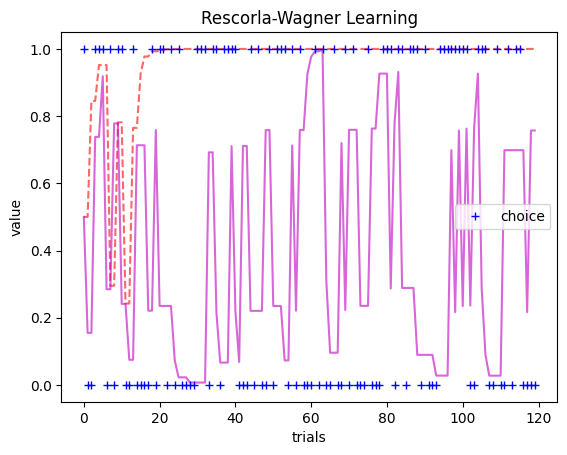

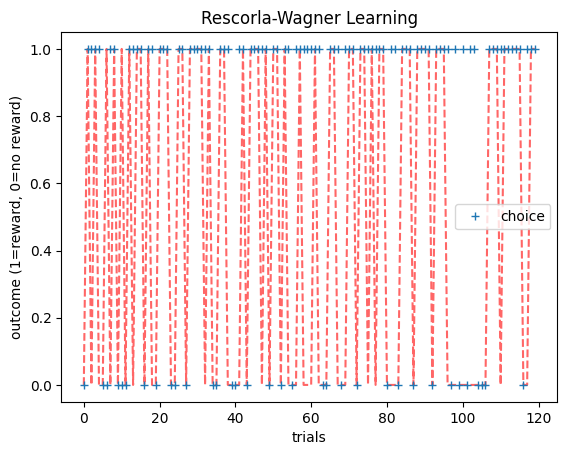

In [224]:


plot_Q_estimates(_res)
plot_reward(_res)
plot_prob_success(_res)


---
# Simulate 
---

In [230]:
T = 250
K = 2
mu = [0.1, 0.9] # reward probabilities

# True (unknown) parameters
alpha = .3
theta = 2.5
params = [alpha, theta]


# simulate 
srw = RescorlaWagnerSimulate()
c3, r3, Q = srw.simulate(params, T=T, mu=mu, noisy_choice=True)

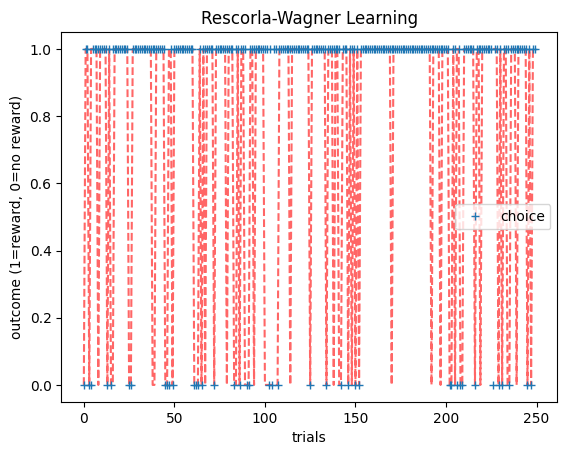

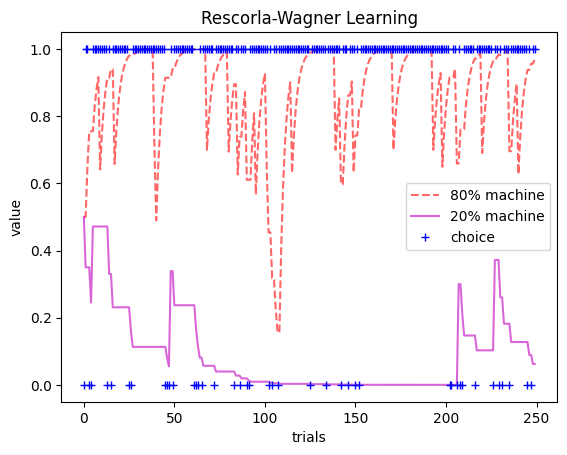

In [231]:
_plt = srw.plot_reward()
_plt.show()

_plt = srw.plot_Q_estimates()
_plt.show()

In [232]:
REWARD_VECTOR = srw.r

Q_stored, predicted_action_vector, action_probabilities = \
   RoscorlaWagerModelDiagnostics.generate_Q_values(
      param_fits,
      action_vector=srw.c,
      reward_vector=srw.r)

In [237]:

x_vector, prob_of_success = RoscorlaWagerModelDiagnostics.calc_prob_of_success(REWARD_VECTOR, bin_size=10)

frac = 0.4
x_loess, y_loess = RoscorlaWagerModelDiagnostics.fit_loess(x_vector, prob_of_success, frac=frac)
fig = RescorlaWagnerPlots.plot_metric(x_vector, prob_of_success)
fig.add_trace(go.Scatter(x=x_loess, y=y_loess, mode='lines', line_color='red', name=f'loess frac:{frac}'))


In [129]:

def fit_experiment(EXPERIMENT_KEY=None, KEY=None, experiment_id=None):
    # data = []
    _meta_data_object = {}
    results = {}
    # 
    # results['subject_ID'] = []
    # results['session_Type'] = []
    # results['session_Num'] = []
    results['experiment'] = []
    results['experiment_id'] = [experiment_id]
    results['subject_ID'] = []
    results['session_Type'] = []
    results['session_Num'] = []

    results['alpha'] = []
    results['theta'] = []
    results['BIC'] = []

    # add metrics
    _metrics = ['TP','FP','TN','FN','senstivity','specificity','precision','recall','accuracy','F_score']
    results.update({k:[] for k in _metrics})


    qsd = QuerySequenceData(StimCode, RespCode)

    if EXPERIMENT_KEY is not None:
        # run experiment over key set
        for experiment in EXPERIMENT_KEY:
            qsd.filter_sequences(*experiment, update_existing_stim_resp=True)
        
        experiment_key = EXPERIMENT_KEY

    if KEY is not None:
        # run single key experiment
        qsd.filter_sequences(*KEY, update_existing_stim_resp=False)
        experiment_key = [KEY]
    

    # extract and flatten parameters
    qsd.extract_stim_resp_data()
    qsd.infer_action_reward_pairs()
    ACTIONS = qsd._action
    REWARDS = qsd._reward

    try:
        param_fits, BIC = RoscorlaWagner.fit_rescorla_wagner_model_n_times(
            action_vector=ACTIONS,
            reward_vector=REWARDS,
            alpha_range=np.linspace(0,1,10),
            theta_range=np.linspace(1,10,10),
            alpha_bound=(0,1),
            theta_bound=(0,10), log=False)
        
        # run model diagnostics
        Q_stored, predicted_action_vector, action_probabilities = \
            RoscorlaWagerModelDiagnostics.generate_Q_values(param_fits, action_vector=ACTIONS, reward_vector=REWARDS)
        
        # store data
        _meta_data_object = {
            'experiment': experiment_key,
            'experiment_id': experiment_id,
            'Q_stored': Q_stored,
            'predicted_action_vector': predicted_action_vector,
            'action_probabilities': action_probabilities,
            'action_vector': ACTIONS,
            'reward_vector': REWARDS
            }
        
        # data.append(_data_object)
        
        # Calc metrics (dict)
        metrics = RoscorlaWagerModelDiagnostics.calc_confusion_matrix(ACTIONS, predicted_action_vector, bin_size=None)
        FAILED_EXPERIMENT = False
        
    except Exception as e:
        print(f'Experiment failed: {experiment_key}. Error: {e}')
        param_fits = [np.nan, np.nan]
        BIC = np.nan
        metrics = {k:None for k in ['TP','FP','TN','FN','senstivity','specificity','precision','recall','accuracy','F_score']}
        FAILED_EXPERIMENT = True

    # deprecated
    # results['subject_ID'].append(KEY[0])
    # results['session_Type'].append(KEY[1])
    # results['session_Num'].append(KEY[2])

    # new
    subject_mode = statistics.mode([i[0] for i in experiment_key])
    session_mode = statistics.mode([i[1] for i in experiment_key])
    session_num_mode = statistics.mode([i[2] for i in experiment_key])

    results['experiment'].append(experiment_key)
    results['subject_ID'].append(subject_mode)
    results['session_Type'].append(session_mode)
    results['session_Num'].append(session_num_mode)
    

    # add results
    results['alpha'].append(param_fits[0])
    results['theta'].append(param_fits[1])
    results['BIC'].append(BIC)
    for k in metrics.keys():
        results[k].append(metrics[k])
    


    return results, _meta_data_object, FAILED_EXPERIMENT

In [130]:
# deprecated
def run_all_experiments_v0(qsd):
    raise DeprecationWarning
    results = None
    data = None
    for exp in tqdm(qsd.StimCode.keys()):
        _results, _data = fit_experiment(exp)
        if results is None:
            results = pd.DataFrame(_results)
        else:
            results = pd.concat([results, pd.DataFrame(_results)])

        if data is None:
            data = _data
        else:
            data = {**data, **_data}
    return results, data
    


def run_all_experiments(experiments, log_progress=True):
    results = None
    data = []
    failed_experiments = []
    experiments = experiments if not log_progress else tqdm(experiments)
    for _idx, _experiment in enumerate(experiments):
        _results, _data, _failed_experiment = fit_experiment(EXPERIMENT_KEY=_experiment, experiment_id=_idx)
        if results is None:
            results = pd.DataFrame(_results)
        else:
            results = pd.concat([results, pd.DataFrame(_results)])
        data.append(_data)
        if _failed_experiment:
            failed_experiments.append(_experiment)
    return results, data
    


In [98]:
# for _experiment in experiments:
#     _results, _data = fit_experiment(EXPERIMENT_KEY=_experiment)
#     break

In [131]:
results, data = run_all_experiments(experiments)


 26%|██▌       | 26/100 [00:05<00:17,  4.29it/s]/var/folders/kd/p1z7_f_974d7tkw1zmvskn_m0000gn/T/ipykernel_85550/1512558058.py:31: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

 28%|██▊       | 28/100 [00:06<00:14,  5.12it/s]

Experiment failed: [(6, 'eds1', None), (6, 'eds2', None)]. Error: float division by zero


 33%|███▎      | 33/100 [00:07<00:13,  5.11it/s]

Experiment failed: [(7, 'eds1', None), (7, 'eds2', None)]. Error: float division by zero


 79%|███████▉  | 79/100 [00:18<00:04,  4.99it/s]

Experiment failed: [(18, 'training', None)]. Error: Action space should be 2. Larger action space not implemented. Got: [] unique actions.


100%|██████████| 100/100 [00:23<00:00,  4.28it/s]


In [132]:
results.sort_values('accuracy', ascending=False).head(3)

,experiment,experiment_id,subject_ID,session_Type,session_Num,alpha,theta,BIC,TP,FP,TN,FN,senstivity,specificity,precision,recall,accuracy,F_score
0,"[(5, training, None)]",24,5,training,None,1.00000,0.303952,174.189261,39,21,33,27,0.590909,0.611111,0.650000,0.590909,0.600000,0.619048
0,"[(9, training, None)]",44,9,training,None,1.00000,0.795413,90.009208,7,23,28,2,0.777778,0.549020,0.233333,0.777778,0.583333,0.358974
0,"[(4, staircase1, None), (4, staircase2, None)]",18,4,staircase1,None,0.84765,0.558507,338.846582,40,80,96,24,0.625000,0.545455,0.333333,0.625000,0.566667,0.434783


In [139]:
# actions

_data = data[24]
_data.keys()

dict_keys(['experiment', 'experiment_id', 'Q_stored', 'predicted_action_vector', 'action_probabilities', 'action_vector', 'reward_vector'])

In [147]:
np.shape(_action_probabilities), len(actions)

((240, 2), 120)

ValueError: x and y must have same first dimension, but have shapes (2,) and (120,)

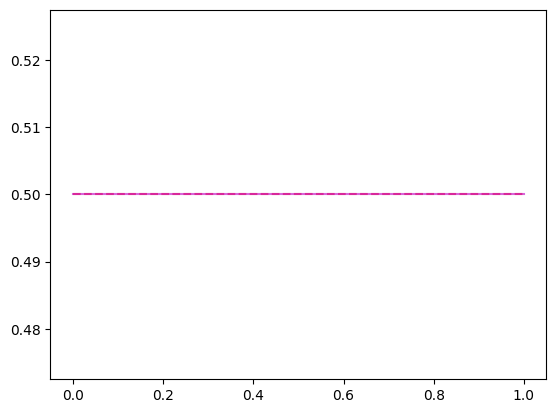

In [144]:
KEY = (5, 'training', None)
alpha = 1
theta = 0.303952
_Q_stored, _predicted_action_vector, _action_probabilities = \
    RoscorlaWagerModelDiagnostics.generate_Q_values([alpha, theta], action_vector=ACTIONS, reward_vector=REWARDS)
_action_probabilities

_data = data[24]
# Q_stored = _data['Q_stored']
# actions = _data['action_vector']
actions = _data['action_vector']

RescorlaWagnerPlots.plot_Q_estimates(Q_values=np.array(_action_probabilities), choice_vector=actions)

0.5074169530355097 0.020587756503107214 0.5


,experiment,subject_ID,session_Type,session_Num,alpha,theta,BIC,TP,FP,TN,FN,senstivity,specificity,precision,recall,accuracy,F_score
0,"[(1, ams1, None), (1, ams2, None)]",1,ams1,None,0.000000,1.000000,343.671925,0,120,120,0,NaN,0.5,0.000000,NaN,0.5,NaN
0,"[(1, eds1, None), (1, eds2, None)]",1,eds1,None,0.690092,0.254189,175.110376,59,1,1,59,0.5,0.5,0.983333,0.5,0.5,0.662921


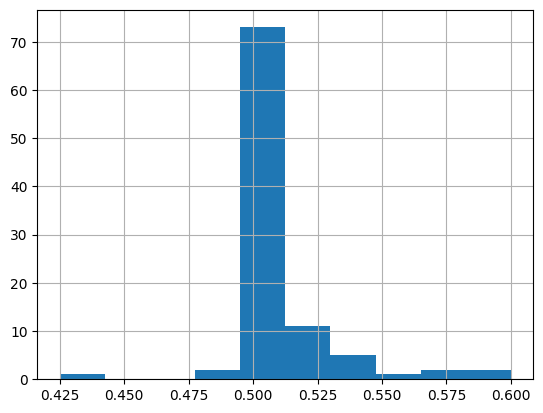

In [101]:
results.accuracy.hist()
print(results.accuracy.mean(), results.accuracy.std(), results.accuracy.median())
results.head(2)
# [exp for exp in results.experiment]



In [102]:

# results, data = run_all_experiments(qsd)


In [103]:
# fig = px.scatter(results, x='BIC', y='accuracy', color='session_Type', hover_data=['subject_ID', 'session_Num'])
# fig.update_layout(template='plotly_dark', title='Distribution of Learning Estimates')
# fig.show()


def plot_accuracy_distribution(results, title=''):
    fig = px.box(results, x='session_Type', y='accuracy', color='session_Type',
                 hover_data=['subject_ID', 'session_Type', 'session_Num', 'accuracy'])
    fig.update_layout(template='plotly_dark', title='')
    fig.add_hline(y=0.5, line=dict(color='red', width=1, dash='dash'))
    return fig

plot_accuracy_distribution(results)

In [104]:

def plot_distribution_of_learning_parameters(results):
    fig = go.Figure()
    fig.add_trace(go.Histogram(x=results['alpha'], name='alpha'))
    fig.add_trace(go.Histogram(x=results['theta'], name='theta'))
    fig.update_layout(template='plotly_dark', title='Distribution of Learning Parameters')
    return fig


def plot_scatter_learning_parameters(results, color='session_Type', log_x=False, log_y=False):
    fig = px.scatter(results, x='alpha', y='theta', color=color, hover_data=['subject_ID', 'session_Num', 'BIC'])
    if log_x:
        fig.update_xaxes(type='log')
    if log_y:
        fig.update_yaxes(type='log')
    fig.update_layout(template='plotly_dark', title='Scatter Plot of Learning Parameters')
    return fig

In [105]:

# plot_distribution_of_learning_parameters(results).show()
# plot_scatter_learning_parameters(results, True, True).show()
plot_scatter_learning_parameters(results).show()
plot_scatter_learning_parameters(results, color='accuracy').show()



In [106]:
results.sort_values(by='accuracy', ascending=False).head(10)


#    fig = px.box(results, x='session_Type', y='accuracy', color='session_Type',
#                  hover_data=['subject_ID', 'session_Type', 'session_Num', 'accuracy'])
#     fig.update_layout(template='plotly_dark', title='')
#     fig.add_hline(y=0.5, line=dict(color='red', width=1, dash='dash'))
#     return fig


def plot_distribution(results, x='accuracy'):
    fig = px.histogram(results, x='accuracy', color='session_Type', nbins=100)
    fig.update_layout(template='plotly_dark', title='')
    fig.add_vline(x=0.5, line=dict(color='red', width=3, dash='dash'))
    fig.show()

plot_distribution(results)

In [112]:
# results.head()
# KEY = (1,'training', 1)
# KEY = (1, 'eds1', 0)
# _data = data[KEY]
_data = data[0]

# _data.keys()

x_vector, prob_of_success = RoscorlaWagerModelDiagnostics.calc_prob_of_success(_data['reward_vector'], bin_size=2)

frac = 0.1
x_loess, y_loess = RoscorlaWagerModelDiagnostics.fit_loess(x_vector, prob_of_success, frac=frac)
fig = RescorlaWagnerPlots.plot_metric(x_vector, prob_of_success, name='Probability of Success')
fig.add_trace(go.Scatter(x=x_loess, y=y_loess, mode='lines', line_color='red', name=f'loess frac:{frac}'))
fig.show()

In [124]:
# _data[0]
results

,experiment,subject_ID,session_Type,session_Num,alpha,theta,BIC,TP,FP,TN,FN,senstivity,specificity,precision,recall,accuracy,F_score
0,"[(1, ams1, None), (1, ams2, None)]",1,ams1,None,0.000000,1.000000,343.671925,0,120,120,0,NaN,0.500000,0.000000,NaN,0.500000,NaN
0,"[(1, eds1, None), (1, eds2, None)]",1,eds1,None,0.690092,0.254189,175.110376,59,1,1,59,0.500000,0.500000,0.983333,0.500000,0.500000,0.662921
0,"[(1, ids1, None), (1, ids2, None)]",1,ids1,None,0.000000,1.000000,259.918899,90,0,0,90,0.500000,NaN,1.000000,0.500000,0.500000,0.666667
0,"[(1, staircase1, None), (1, staircase2, None)]",1,staircase1,None,0.000000,1.000000,259.918899,90,0,0,90,0.500000,NaN,1.000000,0.500000,0.500000,0.666667
0,"[(1, training, None)]",1,training,None,0.000000,1.000000,175.930307,60,0,0,60,0.500000,NaN,1.000000,0.500000,0.500000,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,"[(22, ams1, None), (22, ams2, None)]",22,ams1,None,0.000000,1.000000,343.671925,0,120,120,0,NaN,0.500000,0.000000,NaN,0.500000,NaN
0,"[(22, eds1, None), (22, eds2, None)]",22,eds1,None,0.000000,1.000000,175.930307,0,60,60,0,NaN,0.500000,0.000000,NaN,0.500000,NaN
0,"[(22, ids1, None), (22, ids2, None)]",22,ids1,None,0.000000,1.000000,175.930307,0,60,60,0,NaN,0.500000,0.000000,NaN,0.500000,NaN
0,"[(22, staircase1, None), (22, staircase2, None)]",22,staircase1,None,0.203045,0.533597,342.680079,39,81,80,40,0.493671,0.496894,0.325000,0.493671,0.495833,0.391960


idx:  8
Q_stored: 


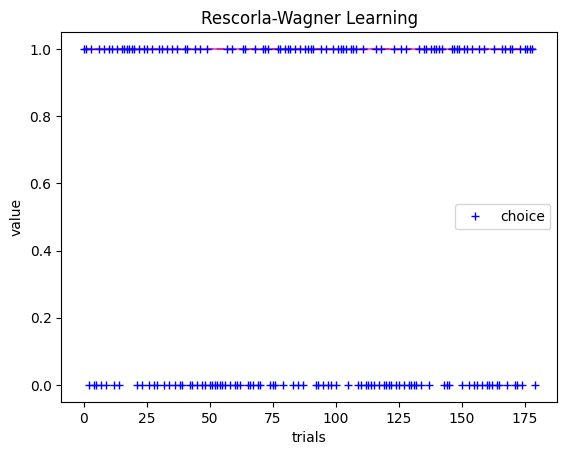

In [121]:


def sample_q_value():

    # _res = results.sample(1)
    # KEY = (_res['subject_ID'].values[0], _res['session_Type'].values[0], _res['session_Num'].values[0])
    # print('KEY: ', KEY)

    idx = np.random.choice(len(data))
    _data = data[idx]
    print('idx: ', idx)

    # _data.keys()

    x_vector, prob_of_success = RoscorlaWagerModelDiagnostics.calc_prob_of_success(_data['reward_vector'], bin_size=2)

    # frac = 0.4
    # x_loess, y_loess = RoscorlaWagerModelDiagnostics.fit_loess(x_vector, prob_of_success, frac=frac)
    # fig = RescorlaWagnerPlots.plot_metric(x_vector, prob_of_success)
    # fig.add_trace(go.Scatter(x=x_loess, y=y_loess, mode='lines', line_color='red', name=f'loess frac:{frac}'))
    # fig.show()

    
    

    Q_stored = _data['Q_stored']
    actions = _data['action_vector']

    RescorlaWagnerPlots.plot_Q_estimates(Q_values=Q_stored, choice_vector=actions)

    print('Q_stored: ')
    # print(Q_stored)

    return KEY, _data


KEY, _data = sample_q_value()


In [ ]:
_data.keys()
# _data['predicted_action_vector']

dict_keys(['Q_stored', 'predicted_action_vector', 'action_probabilities', 'action_vector', 'reward_vector'])

In [ ]:
_df = pd.DataFrame({'action_pred':_data['predicted_action_vector'],
  'action_true':_data['action_vector']})

from sklearn.metrics import confusion_matrix
_df = confusion_matrix(y_true=_data['action_vector'], y_pred=_data['predicted_action_vector'])
print(_df)
print('Acc: ', (_df[0,0] + _df[1,1]) / _df.sum().sum())


[[28  2]
 [25  5]]
Acc:  0.55


In [120]:
_data['action_probabilities']

[[0.5068382777498446, 0.4931617222501554],
 [0.5068382777498446, 0.4931617222501554],
 [0.5068382777498446, 0.4931617222501554],
 [0.5068382777498446, 0.4931617222501554],
 [0.5068382777498446, 0.4931617222501554],
 [0.5068382777498446, 0.4931617222501554],
 [0.5068382777498446, 0.4931617222501554],
 [0.5068382777498446, 0.4931617222501554],
 [0.5068382777498446, 0.4931617222501554],
 [0.5068382777498446, 0.4931617222501554],
 [0.5068382777498446, 0.4931617222501554],
 [0.5068382777498446, 0.4931617222501554],
 [0.5068382777498446, 0.4931617222501554],
 [0.5068382777498446, 0.4931617222501554],
 [0.5068382777498446, 0.4931617222501554],
 [0.5068382777498446, 0.4931617222501554],
 [0.5068382777498446, 0.4931617222501554],
 [0.5068382777498446, 0.4931617222501554],
 [0.5068382777498446, 0.4931617222501554],
 [0.5068382777498446, 0.4931617222501554],
 [0.5068382777498446, 0.4931617222501554],
 [0.5068382777498446, 0.4931617222501554],
 [0.5068382777498446, 0.4931617222501554],
 [0.5068382

In [ ]:
def model_action_prediction_accuracy(action_vector_true, action_vector_predicted):
    _df = confusion_matrix(y_true=action_vector_true, y_pred=action_vector_predicted)
    _acc = (_df[0,0] + _df[1,1]) / _df.sum().sum()
    return _acc


accs = []
for key, value in data.items():
    action_pred = value['predicted_action_vector']
    action_true = value['action_vector']
    _df = confusion_matrix(y_true=action_true, y_pred=action_pred)
    _acc = (_df[0,0] + _df[1,1]) / _df.sum().sum()
    # print(f'{key} - Acc: ', _acc)
    accs.append(_acc)

accs = np.array(accs)
print(accs.mean(), np.median(accs))
px.histogram(accs)

0.5135687732342008 0.5


In [ ]:
KEY
value.keys()
Qa, Qb = value['Q_stored']
print('Qa: ', Qa[:2], Qa[-2:])
print('Qb: ', Qb[:2], Qb[-2:])

Qa:  [0.87578854 0.87578854] [0.99934293 0.99945158]
Qb:  [0.62903855 0.52501967] [0.9936825 0.9936825]


In [ ]:
results[results['subject_ID']==KEY[0] ]


,subject_ID,session_Type,session_Num,alpha,theta,BIC,TP,FP,TN,FN,senstivity,specificity,precision,recall,accuracy,F_score
0,4,training,0,0.000000,1.000000,91.366351,23,7,26,4,0.851852,0.787879,0.766667,0.851852,0.816667,0.807018
0,4,training,1,0.000000,1.000000,91.366351,17,13,11,19,0.472222,0.458333,0.566667,0.472222,0.466667,0.515152
0,4,ids1,0,1.000000,1.377759,82.093471,21,9,4,26,0.446809,0.307692,0.700000,0.446809,0.416667,0.545455
0,4,staircase1,0,0.552039,1.434849,88.895719,27,3,2,28,0.490909,0.400000,0.900000,0.490909,0.483333,0.635294
0,4,staircase1,1,0.000000,1.000000,91.366351,16,14,5,25,0.390244,0.263158,0.533333,0.390244,0.350000,0.450704
0,4,ams1,0,0.000000,1.000000,91.366351,10,20,10,20,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
0,4,ams1,1,0.001257,10.000000,91.304266,15,15,6,24,0.384615,0.285714,0.500000,0.384615,0.350000,0.434783
0,4,eds1,0,0.773284,0.453927,90.332376,18,12,9,21,0.461538,0.428571,0.600000,0.461538,0.450000,0.521739
0,4,ids2,0,1.000000,0.451330,91.254387,27,3,1,29,0.482143,0.250000,0.900000,0.482143,0.466667,0.627907
0,4,staircase2,0,1.000000,0.427182,90.942260,27,3,2,28,0.490909,0.400000,0.900000,0.490909,0.483333,0.635294


<module 'matplotlib.pyplot' from '/Users/zachwolpe/miniforge3/envs/mlxgo/lib/python3.12/site-packages/matplotlib/pyplot.py'>

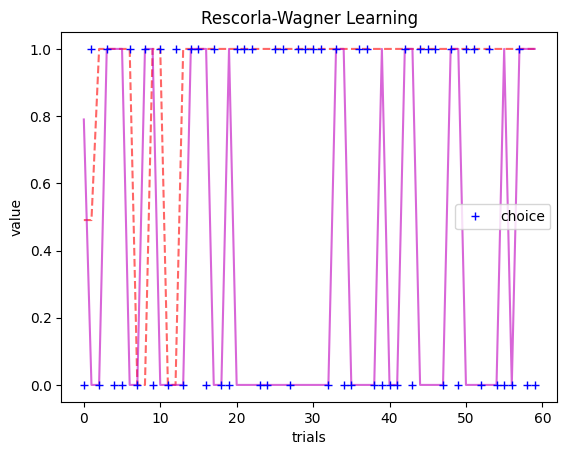

In [ ]:
Q_stored = _data['Q_stored']
actions = _data['action_vector']

RescorlaWagnerPlots.plot_Q_estimates(Q_values=Q_stored, choice_vector=actions)

In [ ]:
# results_rat
# _data = data_rat[(1,'training',1)]
# _data.keys()
# _data['Q_stored']
# _data['predicted_action_vector']
# _data['action_probabilities']


x_vector, prob_of_success = RoscorlaWagerModelDiagnostics.calc_prob_of_success(_data['reward_vector'], bin_size=2)

frac = 0.4
x_loess, y_loess = RoscorlaWagerModelDiagnostics.fit_loess(x_vector, prob_of_success, frac=frac)
fig = RescorlaWagnerPlots.plot_metric(x_vector, prob_of_success)
fig.add_trace(go.Scatter(x=x_loess, y=y_loess, mode='lines', line_color='red', name=f'loess frac:{frac}'))


In [ ]:
results

results_rat
_data = data_rat[(1,'training',1)]
_data.keys()
_data['Q_stored']
_data['predicted_action_vector']
_data['action_probabilities']


x_vector, prob_of_success = RoscorlaWagerModelDiagnostics.calc_prob_of_success(_data['reward_vector'], bin_size=2)

frac = 0.4
x_loess, y_loess = RoscorlaWagerModelDiagnostics.fit_loess(x_vector, prob_of_success, frac=frac)
fig = RescorlaWagnerPlots.plot_metric(x_vector, prob_of_success)
fig.add_trace(go.Scatter(x=x_loess, y=y_loess, mode='lines', line_color='red', name=f'loess frac:{frac}'))


,subject_ID,session_Type,session_Num,alpha,theta,BIC,TP,FP,TN,FN,senstivity,specificity,precision,recall,accuracy,F_score
0,1,training,0,1.000000,0.017168,91.362059,30,0,30,0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0,1,training,1,0.000000,1.000000,91.366351,22,8,16,14,0.611111,0.666667,0.733333,0.611111,0.633333,0.666667
0,1,ids1,0,0.000000,1.000000,91.366351,28,2,0,30,0.482759,0.000000,0.933333,0.482759,0.466667,0.636364
0,1,staircase1,0,0.000000,1.000000,91.366351,28,2,0,30,0.482759,0.000000,0.933333,0.482759,0.466667,0.636364
0,1,staircase1,1,1.000000,0.367699,90.360802,18,12,7,23,0.439024,0.368421,0.600000,0.439024,0.416667,0.507042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,22,staircase2,0,0.186683,0.958559,91.262546,28,2,1,29,0.491228,0.333333,0.933333,0.491228,0.483333,0.643678
0,22,staircase2,1,0.083563,1.850284,90.598534,19,11,6,24,0.441860,0.352941,0.633333,0.441860,0.416667,0.520548
0,22,ams2,0,0.000000,1.000000,91.366351,12,18,15,15,0.444444,0.454545,0.400000,0.444444,0.450000,0.421053
0,22,ams2,1,0.000000,1.000000,91.366351,14,16,18,12,0.538462,0.529412,0.466667,0.538462,0.533333,0.500000


---
# Rat Learning
----

In [ ]:
(data,
 sequence_data,
 meta_data,
 StimCode,
 RespCode
 ) = load_data(config=_config, experiment_class='rat_experiment')
qsd = QuerySequenceData(StimCode, RespCode)
# rewards, _qsd = reward_per_experiment(qsd, StimCode)

# # drop na
# rewards = rewards[~rewards.reward_rate.isna()]

In [ ]:



results_rat, data_rat = run_all_experiments(qsd)

  3%|▎         | 8/284 [00:01<00:59,  4.68it/s]/Users/zachwolpe/Desktop/µπ/perceptual_attention_learning/reinforcement_learning/src/rescorla_wagner_model.py:96: RuntimeWarning:

divide by zero encountered in log

/Users/zachwolpe/miniforge3/envs/mlxgo/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning:

invalid value encountered in subtract

  9%|▉         | 25/284 [00:05<01:02,  4.12it/s]/var/folders/kd/p1z7_f_974d7tkw1zmvskn_m0000gn/T/ipykernel_33263/1320288949.py:9: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

100%|██████████| 284/284 [00:51<00:00,  5.53it/s]


In [ ]:
results_rat
_data = data_rat[(1,'training',1)]
_data.keys()
_data['Q_stored']
_data['predicted_action_vector']
_data['action_probabilities']


x_vector, prob_of_success = RoscorlaWagerModelDiagnostics.calc_prob_of_success(_data['reward_vector'], bin_size=2)

frac = 0.4
x_loess, y_loess = RoscorlaWagerModelDiagnostics.fit_loess(x_vector, prob_of_success, frac=frac)
fig = RescorlaWagnerPlots.plot_metric(x_vector, prob_of_success)
fig.add_trace(go.Scatter(x=x_loess, y=y_loess, mode='lines', line_color='red', name=f'loess frac:{frac}'))


----
# Fit Q-Learning model to Human Pilot Data
---

In [ ]:
len(qsd._respCodeFlat)


840

In [ ]:
ACTIONS = qsd._action[800:1000]
REWARDS = qsd._reward[800:1000]
ACTIONS = qsd._action
REWARDS = qsd._reward

# sklearn confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(ACTIONS, REWARDS)


RoscorlaWagerModelDiagnostics.compute_TP_FP_TN_FN(ACTIONS, REWARDS)
RoscorlaWagerModelDiagnostics.calc_confusion_matrix(ACTIONS, REWARDS, bin_size=None)

{'TP': 354,
 'FP': 66,
 'TN': 180,
 'FN': 240,
 'senstivity': 0.5959595959595959,
 'specificity': 0.7317073170731707,
 'precision': 0.8428571428571429,
 'recall': 0.5959595959595959,
 'accuracy': 0.6357142857142857,
 'F_score': 0.6982248520710058}

In [ ]:


x_vector, prob_of_success = RoscorlaWagerModelDiagnostics.calc_prob_of_success(REWARDS, bin_size=20)



frac = 0.4
x_loess, y_loess = RoscorlaWagerModelDiagnostics.fit_loess(x_vector, prob_of_success, frac=frac)
fig = RescorlaWagnerPlots.plot_metric(x_vector, prob_of_success)
fig.add_trace(go.Scatter(x=x_loess, y=y_loess, mode='lines', line_color='red', name=f'loess frac:{frac}'))
fig.update_yaxes(range=[0, 1], title='Human (pilot) learning over all trials. \n -> subjectID:{subject_ID}\n -> sessionType:{session_Type}')

fig.show()

In [ ]:
# fetch processed data
# data = load_processed_data('./data/processed_data/')

param_fits, BIC = RoscorlaWagner.fit_rescorla_wagner_model_n_times(
    action_vector=ACTIONS,
    reward_vector=REWARDS,
    alpha_range=np.linspace(0,1,10),
    theta_range=np.linspace(1,25,10),
    alpha_bound=(0,1),
    theta_bound=(0,50))

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 11.66it/s]

Neg Log Likelihood fit complete.
alpha_hat = 0.00, theta_hat = 1.00
BIC = 1177.95


In [ ]:
RoscorlaWagner.grid_search


nLL, grid_df_to_plot = RoscorlaWagner.grid_search(ACTIONS, REWARDS, alpha_range=np.linspace(0,1,100), theta_range=np.linspace(1,25,100))
RescorlaWagnerPlots.plot_grid_opt(grid_df_to_plot)


100%|██████████| 100/100 [00:14<00:00,  7.13it/s]


In [ ]:
Q_stored, predicted_action_vector, action_probabilities = \
   RoscorlaWagerModelDiagnostics.generate_Q_values(
      param_fits,
      action_vector=ACTIONS,
      reward_vector=REWARDS)


<module 'matplotlib.pyplot' from '/Users/zachwolpe/miniforge3/envs/mlxgo/lib/python3.12/site-packages/matplotlib/pyplot.py'>

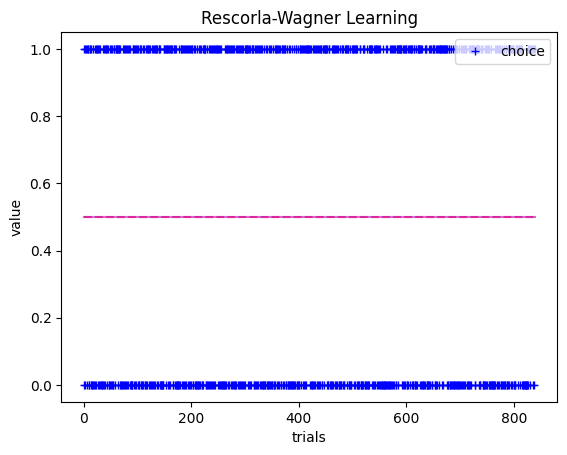

In [ ]:
# Infered
RescorlaWagnerPlots.plot_Q_estimates(Q_values=Q_stored, choice_vector=ACTIONS)

In [ ]:
# qsd = QuerySequenceData(StimCode, RespCode)
# for k,v in RespCode.items():
#     _reward, _action = qsd.infer_action_reward_pairs(v)
#     print(f'Reward: {np.mean(_reward)}')